# **Classifying Images of Everyday Objects Using a Feed Forward Neural Networks**

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

## **Exploring the CIFAR10 dataset**

In [2]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

100%|██████████| 170498071/170498071 [00:02<00:00, 82717298.52it/s]


Extracting data/cifar-10-python.tar.gz to data/


 **Number of images the training dataset contain**

In [3]:
dataset_size= len(dataset)
dataset_size

50000

 **Number of images the test dataset contain**

In [4]:
test_dataset_size = len(test_dataset)
test_dataset_size

10000

**Q: How many output classes does the dataset contain? Can you list them?**

Hint: Use `dataset.classes`

In [5]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
num_classes= len(classes)
num_classes

10

**Q: What is the shape of an image tensor from the dataset?**

In [7]:
img, label= dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

Note that this dataset consists of 3-channel color images (RGB). Let us look at a sample image from the dataset. `matplotlib` expects channels to be the last dimension of the image tensors (whereas in PyTorch they are the first dimension), so we'll the `.permute` tensor method to shift channels to the last dimension. Let's also print the label for the image.

Label (numeric):  6
Label (textual):  frog


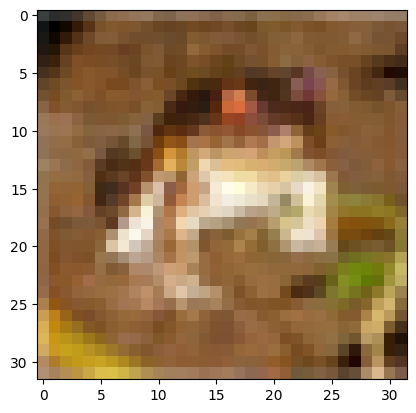

In [8]:
img, label = dataset[0]
plt.imshow(img.permute((1,2,0)))
print('Label (numeric): ', label)
print('Label (textual): ', classes[label])

In [9]:
count_dict = {}
for img, label in dataset:
  the_label = classes[label]
  if the_label not in count_dict:
    count_dict[the_label] = 0
  else:
      count_dict[the_label]+=1



count_dict

{'frog': 4999,
 'truck': 4999,
 'deer': 4999,
 'automobile': 4999,
 'bird': 4999,
 'horse': 4999,
 'ship': 4999,
 'cat': 4999,
 'dog': 4999,
 'airplane': 4999}

## **Preparing the data for training**

We'll use a validation set with 8000 images. To ensure we get the same validation set each time, we'll set PyTorch's random number generator to a seed value of 43.

In [31]:
torch.manual_seed(42)
val_size = 7000
train_size = len(dataset) - val_size

Let's use the `random_split` method to create the training & validation sets

In [32]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds) , len(val_ds)

(43000, 7000)

We can now create data loaders to load the data in batches.

In [33]:
batch_size = 109

In [34]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

Let's visualize a batch of data using the `make_grid` helper function from Torchvision.

images.shape: torch.Size([128, 3, 32, 32])


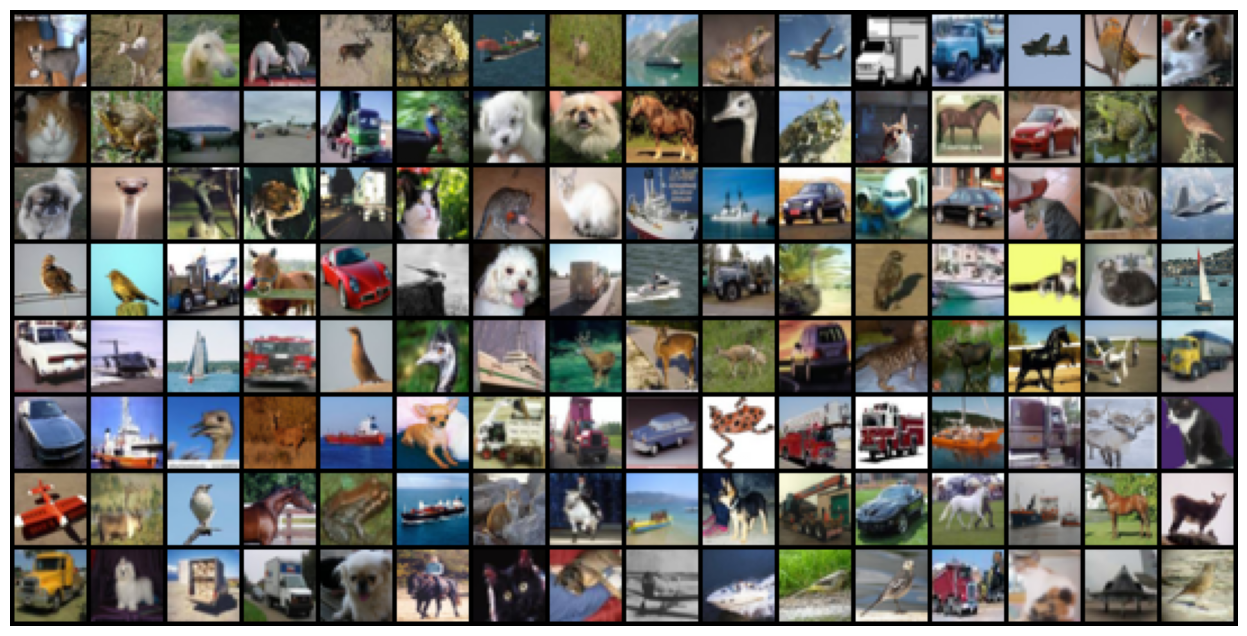

In [14]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## **Base Model class & Training on GPU**

Let's create a base model class, which contains everything except the model architecture i.e. it wil not contain the `__init__` and `__forward__` methods. We will later extend this class to try out different architectures. In fact, you can extend this model to solve any image classification problem.

In [35]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [37]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


We can also use the exact same training loop as before. I hope you're starting to see the benefits of refactoring our code into reusable functions.

In [38]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Finally, let's also define some utilities for moving out data & labels to the GPU, if one is available.

In [39]:
torch.cuda.is_available()

True

In [40]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [41]:
device = get_default_device()
device

device(type='cuda')

In [42]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Let us also define a couple of helper functions for plotting the losses & accuracies.

In [43]:
def plot_losses(history):
  losses = [x['val_loss'] for x in history]
  plt.plot(losses, '-x')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Loss vs. No. of epochs');

In [44]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs');

Let's move our data loaders to the appropriate device.

In [45]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## **Training the model**

We will make several attempts at training the model. Each time, try a different architecture and a different set of learning rates. Here are some ideas to try:
- Increase or decrease the number of hidden layers
- Increase of decrease the size of each hidden layer
- Try different activation functions
- Try training for different number of epochs
- Try different learning rates in every epoch

What's the highest validation accuracy you can get to? **Can you get to 50% accuracy? What about 60%?**

In [46]:
input_size = 3*32*32
output_size = 10


**Q: Extend the `ImageClassificationBase` class to complete the model definition.**

Hint: Define the `__init__` and `forward` methods.

In [50]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 128)
        self.linear2 = nn.Linear(128, 96)
        self.linear3 = nn.Linear(96, 72)
        self.linear4 = nn.Linear(72, 64)
        self.linear5 = nn.Linear(64, 32)
        self.linear6 = nn.Linear(32, output_size)

    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        out = F.relu(out)
        out = self.linear6(out)

        return out

You can now instantiate the model, and move it the appropriate device.

In [51]:
model = to_device(CIFAR10Model(), device)

Before you train the model, it's a good idea to check the validation loss & accuracy with the initial set of weights.

In [52]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3043994903564453, 'val_acc': 0.09899453073740005}]

**Q: Train the model using the `fit` function to reduce the validation loss & improve accuracy.**

Leverage the interactive nature of Jupyter to train the model in multiple phases, adjusting the no. of epochs & learning rate each time based on the result of the previous training phase.

In [53]:
history += fit(5, 0.3, model, train_loader, val_loader)

Epoch [0], val_loss: 2.0995, val_acc: 0.1745
Epoch [1], val_loss: 2.0315, val_acc: 0.2590
Epoch [2], val_loss: 1.9110, val_acc: 0.2960
Epoch [3], val_loss: 1.9433, val_acc: 0.3062
Epoch [4], val_loss: 1.7605, val_acc: 0.3563


In [ ]:
history += fit(7, 0.2, model, train_loader, val_loader)

In [54]:
history += fit(7, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 1.6829, val_acc: 0.3990
Epoch [1], val_loss: 1.6514, val_acc: 0.4081
Epoch [2], val_loss: 1.6494, val_acc: 0.4047
Epoch [3], val_loss: 1.6143, val_acc: 0.4232
Epoch [4], val_loss: 1.6896, val_acc: 0.4011
Epoch [5], val_loss: 1.6663, val_acc: 0.4071
Epoch [6], val_loss: 1.5694, val_acc: 0.4342


In [55]:
history += fit(5, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 1.4938, val_acc: 0.4643
Epoch [1], val_loss: 1.4910, val_acc: 0.4645
Epoch [2], val_loss: 1.4889, val_acc: 0.4645
Epoch [3], val_loss: 1.4910, val_acc: 0.4657
Epoch [4], val_loss: 1.4853, val_acc: 0.4705


In [ ]:
history += fit(5, 0.003, model, train_loader, val_loader)

In [ ]:
history += fit(5, 0.001, model, train_loader, val_loader)

Plot the losses and the accuracies to check if you're starting to hit the limits of how well your model can perform on this dataset. You can train some more if you can see the scope for further improvement.

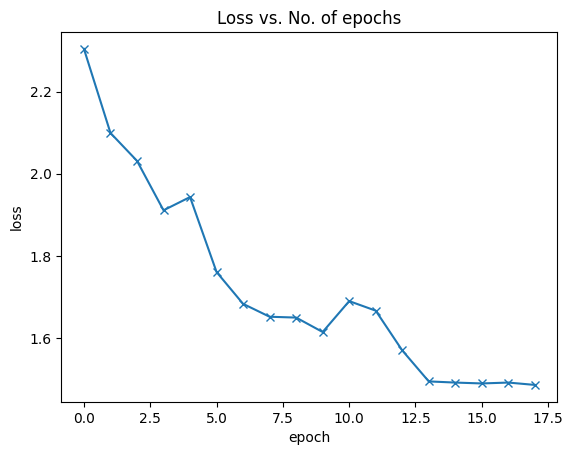

In [56]:
plot_losses(history)

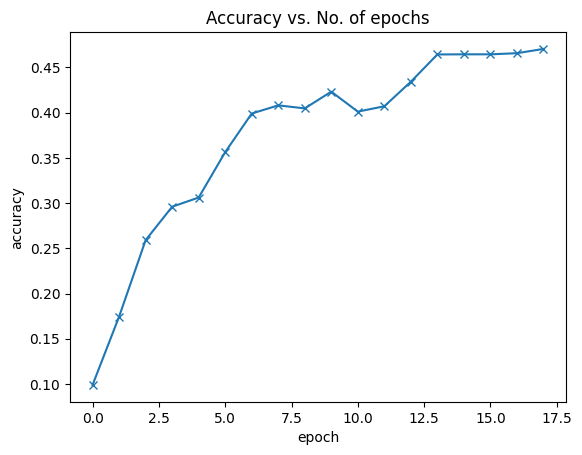

In [57]:
plot_accuracies(history)

## **Testing with individual images**


In [59]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label (numeric):  3 Label (textual):  cat , Predicted: 3


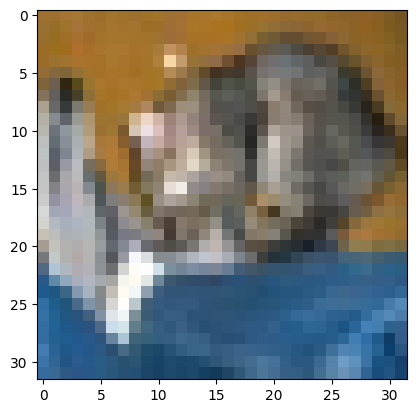

In [63]:
img, label = test_dataset[0]
plt.imshow(img.permute((1,2,0)))
print('Label (numeric): ', label,'Label (textual): ', classes[label] ,', Predicted:', predict_image(img, model))

Label (numeric):  7 Label (textual):  horse , Predicted: 7


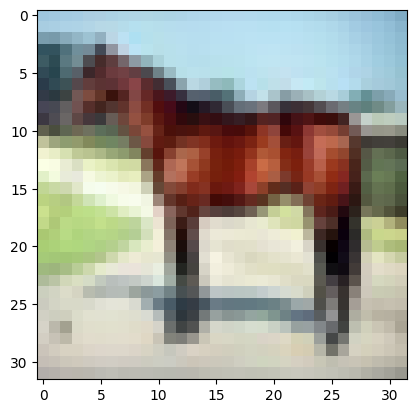

In [64]:
img, label = test_dataset[1839]
plt.imshow(img.permute((1,2,0)))
print('Label (numeric): ', label,'Label (textual): ', classes[label] ,', Predicted:', predict_image(img, model))


Label (numeric):  9 Label (textual):  truck , Predicted: 8


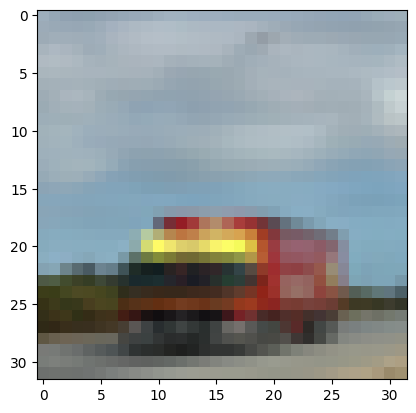

In [66]:
img, label = test_dataset[139]
plt.imshow(img.permute((1,2,0)))
print('Label (numeric): ', label,'Label (textual): ', classes[label] ,', Predicted:', predict_image(img, model))


Finally, evaluate the model on the test dataset report its final performance.

In [58]:
evaluate(model, test_loader)

{'val_loss': 1.451878309249878, 'val_acc': 0.48358696699142456}